Montamos drive para guardar los modelos

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Descargar modelo BioWordVec 
Tiempo aproximado ~ 5 minutos

In [0]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin

--2020-04-25 15:07:46--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 2607:f220:41e:250::12
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G  35.1MB/s    in 6m 7s   

2020-04-25 15:13:54 (35.0 MB/s) - ‘BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



Carga de librerias

In [0]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.models import KeyedVectors
import requests
import pandas as pd
from io import StringIO

Función auxiliar de tokenizacion de textos

In [0]:
def tokenize_text(text):
  tokens=[]
  for sentence in gensim.summarization.textcleaner.get_sentences(text):
    tokens.append(gensim.utils.simple_preprocess(sentence))
  return tokens

Carga del modelo biowordvec

In [0]:
#Cargamos el modelo BioWord que usaremos como base
bioword = KeyedVectors.load_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Creamos un dict con cada enfermedad y su url

In [0]:
#Lista de las fuentes que vamos a scrapear
urls={'covid':'https://librairy.linkeddata.es/solr/covid-paragraphs/select?fl=id%2C%20text_t&q=bionlp_diseases_N5%3Acovid-19&rows=10000&wt=csv',
      'malaria':'https://librairy.linkeddata.es/solr/covid-paragraphs/select?fl=id%2C%20text_t&q=bionlp_diseases_N2%3Amalaria&rows=10000&wt=csv',
      'dengue':'https://librairy.linkeddata.es/solr/covid-paragraphs/select?fl=id%2C%20text_t&q=bionlp_diseases_N4%3Adengue&rows=10000&wt=csv'}

Proceso iterativo de entrenamiento de modelos

In [16]:
for key,item in urls.items():
  #Recuperamos los datos
  print('Currently working on: %s' %key)
  print('Collecting data')
  parsed_data=StringIO(requests.get(item).text)
  print('Parsing data')
  df=pd.read_csv(parsed_data,sep=',')
  del parsed_data
  print('Extracting paragraphs')
  text='\n'.join(df['text_t'].to_list())
  del df
  print('Tokenizing sentences')
  sentences=tokenize_text(text)
  sentences=sentences[:10000]
  #Creamos el modelo
  print('Creating w2v model')
  w2v_model=gensim.models.Word2Vec(size=200,min_count=3,sg=1,seed=1852)
  w2v_model.build_vocab(sentences)
  total_examples = w2v_model.corpus_count
  print('Reading initialization values')
  w2v_model.build_vocab([list(bioword.vocab.keys())], update=True)
  w2v_model.intersect_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True, lockf=1.0)
  print('Training model')
  w2v_model.train(sentences, total_examples=total_examples, epochs=w2v_model.iter)
  print('Saving model')
  model_save_name = key+'.bin'
  path = F"/content/gdrive/My Drive/Drugs4Covid_NLP/Modelos_WordEmbedding/"+model_save_name
  w2v_model.wv.save_word2vec_format(path, binary=True)
  del w2v_model

Currently working on: covid
Parsing data
Extracting paragraphs
Tokenizing sentences
Creating w2v model
Reading initialization values


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Training model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Saving model
Currently working on: malaria
Parsing data
Extracting paragraphs
Tokenizing sentences
Creating w2v model
Reading initialization values
Training model
Saving model
Currently working on: dengue
Parsing data
Extracting paragraphs
Tokenizing sentences
Creating w2v model
Reading initialization values
Training model
Saving model


In [0]:
model_path = F"/content/gdrive/My Drive/Drugs4Covid_NLP/Modelos_WordEmbedding/"+'covid.bin'
model_2 = KeyedVectors.load_word2vec_format(model_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Plot data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


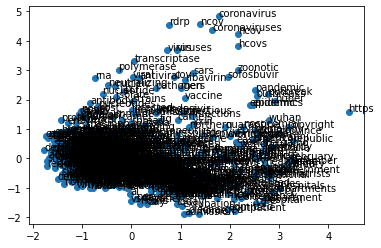

In [0]:
X = model_2[model_2.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model_2.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()